# Multiple Hypothesis Tests

In [1]:
import pandas as pd
import numpy as np
from scipy import stats 
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import t
import seaborn as sns

# Contents of this note
## 1. Type 1 Errors in Multiple Hypothesis Testing
## 2. Multiple testing correction
### - Family Wise Error Rate (FWER)
### - False Discovery Rate (FDR)

# Part 1 - Type 1 Errors in Multiple Hypothesis Testing

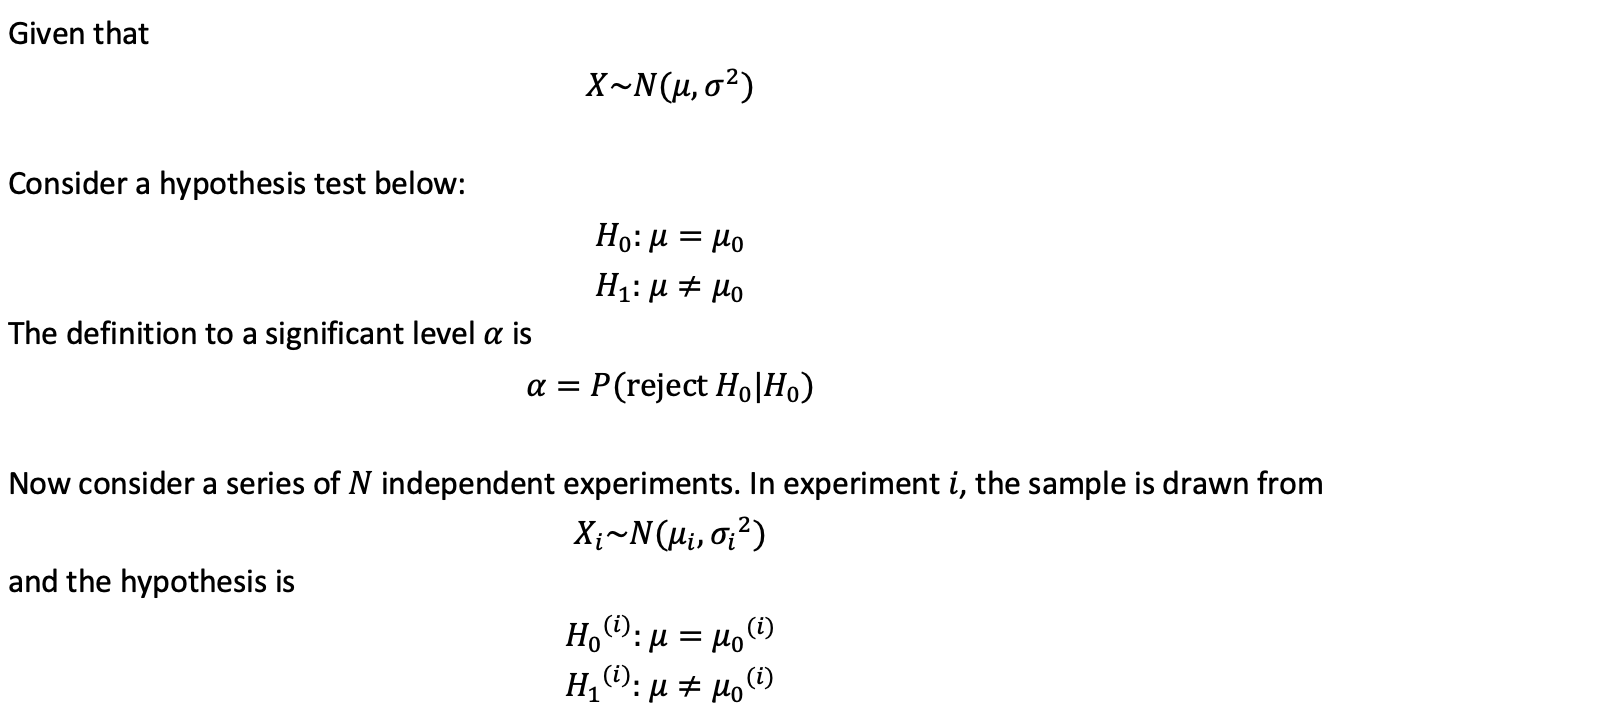

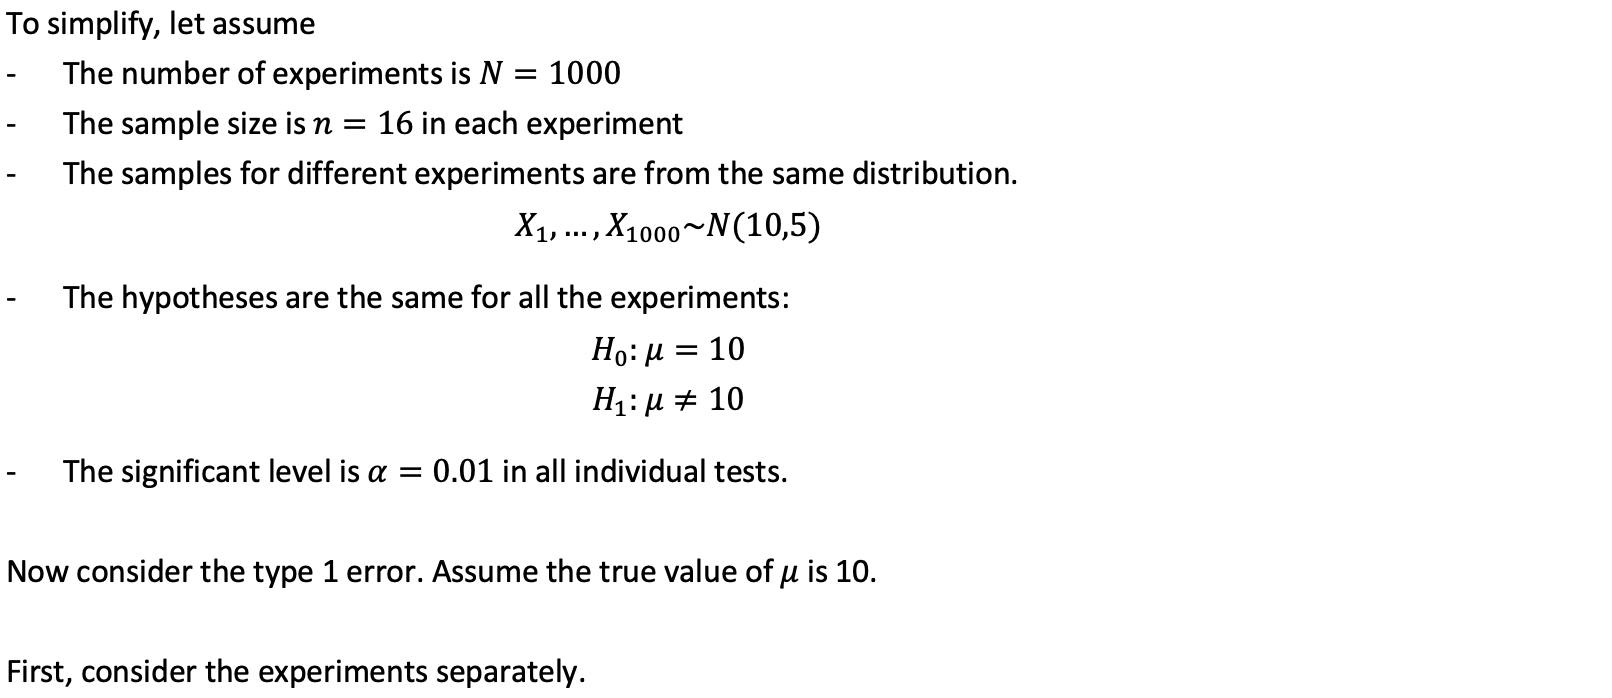

In [2]:
##### true values of the parameters (unknown, will not be used in the tests)
true_mu     = 10
true_sigma2 = 5
##### significant level
alpha       = 0.01

##### number of experiments
n_test      = 1000

##### sample size
sample_size = 16

**The code below run 1000 independent hypothesis tests.**

In [3]:
result = pd.DataFrame(columns=['T','c','p','reject'])
for i in range(n_test):
    sample = np.random.normal(true_mu,np.sqrt(true_sigma2),sample_size)
    sample_mean = np.mean(sample)
    result.loc[i,'T'] = abs(np.sqrt(sample_size)*(sample_mean-true_mu)/np.sqrt(np.var(sample,ddof=1)))
    result.loc[i,'c'] = t.ppf(1-alpha/2, df=sample_size-1)
    result.loc[i,'p'] = (1-t.cdf(result.loc[i,'T'], df=sample_size-1))*2
    result.loc[i,'reject'] = int(result.loc[i,'T']>result.loc[i,'c'])

**The results show that** 
- The null, which is true, is rejected in about 10 tests. 
- This is consistent with the pre-specified level of each individual test (alpha): 1000 * alpha ~ 10
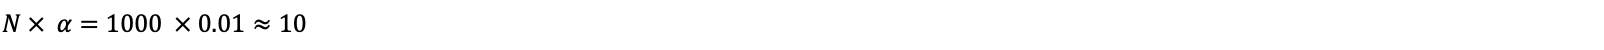

In [4]:
rejected = result[result['reject']==1].sort_values(by='p')
print('Number of tests in which the null is (incorreclty) rejected:', len(rejected))
rejected

Number of tests in which the null is (incorreclty) rejected: 5


,T,c,p,reject
473,4.696229,2.946713,0.000287,1
679,3.829504,2.946713,0.001641,1
250,3.334298,2.946713,0.004529,1
903,3.328249,2.946713,0.004585,1
117,3.015298,2.946713,0.008697,1


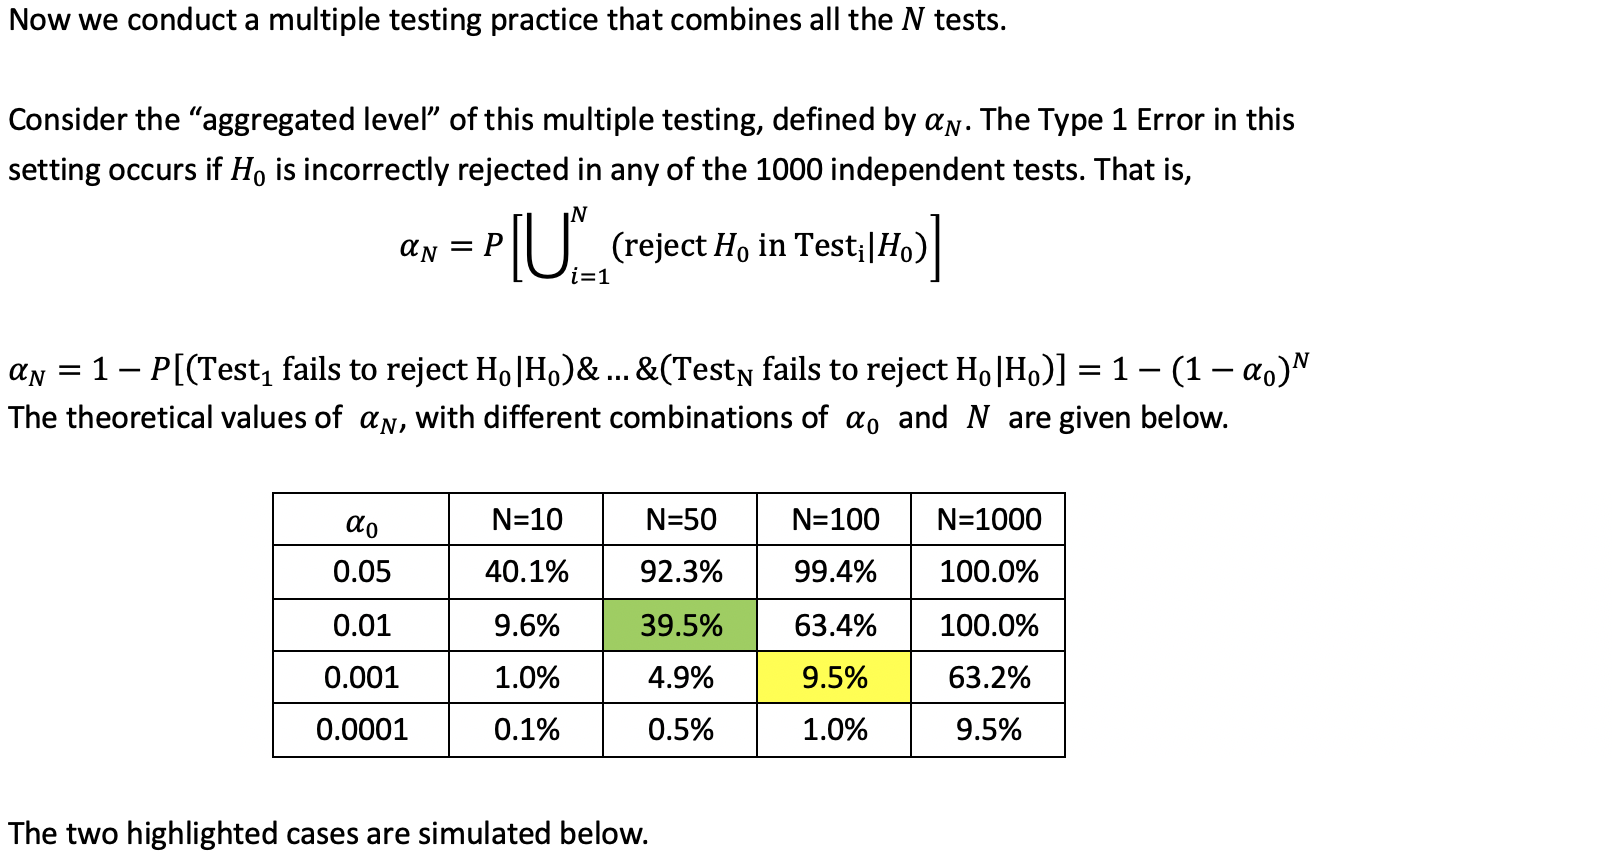

### (1) Case 1: N=50, alpha=0.01 (the green cell)
- 100 multiple testings are conducted. 
- Each test includes 50 independent experiments. 
- In each of the 100 experiments, the number of rejections from the 50 tests could be 0,1,2...,50. But in most cases the number of rejections are low(0,1,2,...). 
- The histogram belows shows the numbers of incorrect rejections from the 100 trails. Theoretically 39.5% of the 100 trials have at least one incorrect rejection (Type 1 Error). This is the "Aggregated Level" of the multiple testing. If N_experiments is large enought, the simulation-based alpha_N will converge to 39.5%.

In [5]:
n_experiment = 100
alpha        = 0.01
n_test       = 50
alpha_N      = [np.nan]*n_experiment
for e in range(n_experiment):
    result = pd.DataFrame(columns=['T','c','p','reject'])
    for i in range(n_test):
        sample = np.random.normal(true_mu,np.sqrt(true_sigma2),sample_size)
        sample_mean = np.mean(sample)
        result.loc[i,'T'] = abs(np.sqrt(sample_size)*(sample_mean-true_mu)/np.sqrt(np.var(sample,ddof=1)))
        result.loc[i,'c'] = t.ppf(1-alpha/2, df=sample_size-1)
        result.loc[i,'p'] = (1-t.cdf(result.loc[i,'T'], df=sample_size-1))*2
        result.loc[i,'reject'] = int(result.loc[i,'T']>result.loc[i,'c'])
    rejected = result[result['reject']==1].sort_values(by='p')
    alpha_N[e] = len(rejected)
len([i for i in alpha_N if i >0])/len(alpha_N)

0.46

In [6]:
### frequency table of the number of rejections
pd.DataFrame(alpha_N).value_counts()

0    54
1    35
2     9
3     2
dtype: int64

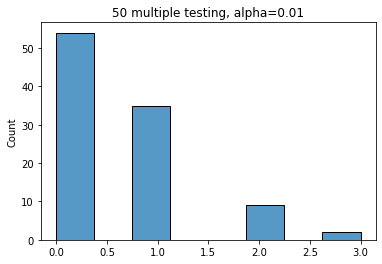

In [7]:
sns.histplot(alpha_N).set(title='50 multiple testing, alpha=0.01')
plt.show()

### (2) N=100, alpha=0.001 (the yellow cell)
- 100 multiple testings are conducted.
- Each test includes 100 independent experiments.
- In each of the 100 experiments, the number of rejections from the 100 tests could be 0,1,2...,100. But in most cases the number of rejections are low(0,1,2,...).
- The histogram belows shows the numbers of incorrect rejections from the 100 trails. Theoretically 9.5% of the 100 trials have at least one incorrect rejection (Type 1 Error). This is the "Aggregated Level" of the multiple testing. If N_experiments is large enought, the simulation-based alpha_N will converge to 9.5%.

In [8]:
n_experiment = 100
alpha   = 0.001
n_test  = 100
alpha_N = [np.nan]*n_experiment
for e in range(n_experiment):
    result = pd.DataFrame(columns=['T','c','p','reject'])
    for i in range(n_test):
        sample = np.random.normal(true_mu,np.sqrt(true_sigma2),sample_size)
        sample_mean = np.mean(sample)
        result.loc[i,'T'] = abs(np.sqrt(sample_size)*(sample_mean-true_mu)/np.sqrt(np.var(sample,ddof=1)))
        result.loc[i,'c'] = t.ppf(1-alpha/2, df=sample_size-1)
        result.loc[i,'p'] = (1-t.cdf(result.loc[i,'T'], df=sample_size-1))*2
        result.loc[i,'reject'] = int(result.loc[i,'T']>result.loc[i,'c'])
    rejected = result[result['reject']==1].sort_values(by='p')
    alpha_N[e] = len(rejected)
len([i for i in alpha_N if i >0])/len(alpha_N)

0.13

In [9]:
### frequency table of the number of rejections
pd.DataFrame(alpha_N).value_counts()

0    87
1    12
2     1
dtype: int64

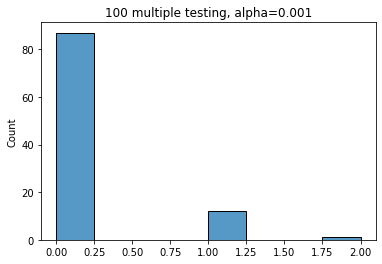

In [10]:
sns.histplot(alpha_N).set(title='100 multiple testing, alpha=0.001')
plt.show()

### As seen in the discussion above, the "aggregated level (Type 1 Error rate)" blows up in the case of multiple hypothesis testing. Next we will find a test design to maintain the aggreged level within an acceptable range.

# Part 2 - Multiple testing correction

## 1: Family Wise Error Rate (FWER)
- ### [FWER](https://en.wikipedia.org/wiki/Family-wise_error_rate) is the probability of making one or more false discoveries, or type 1 errors when performing multiple hypotheses tests.
- ### [Bonferroni Correction](https://en.wikipedia.org/wiki/Bonferroni_correction) is a method controlling the FWER at certain per-specified value.
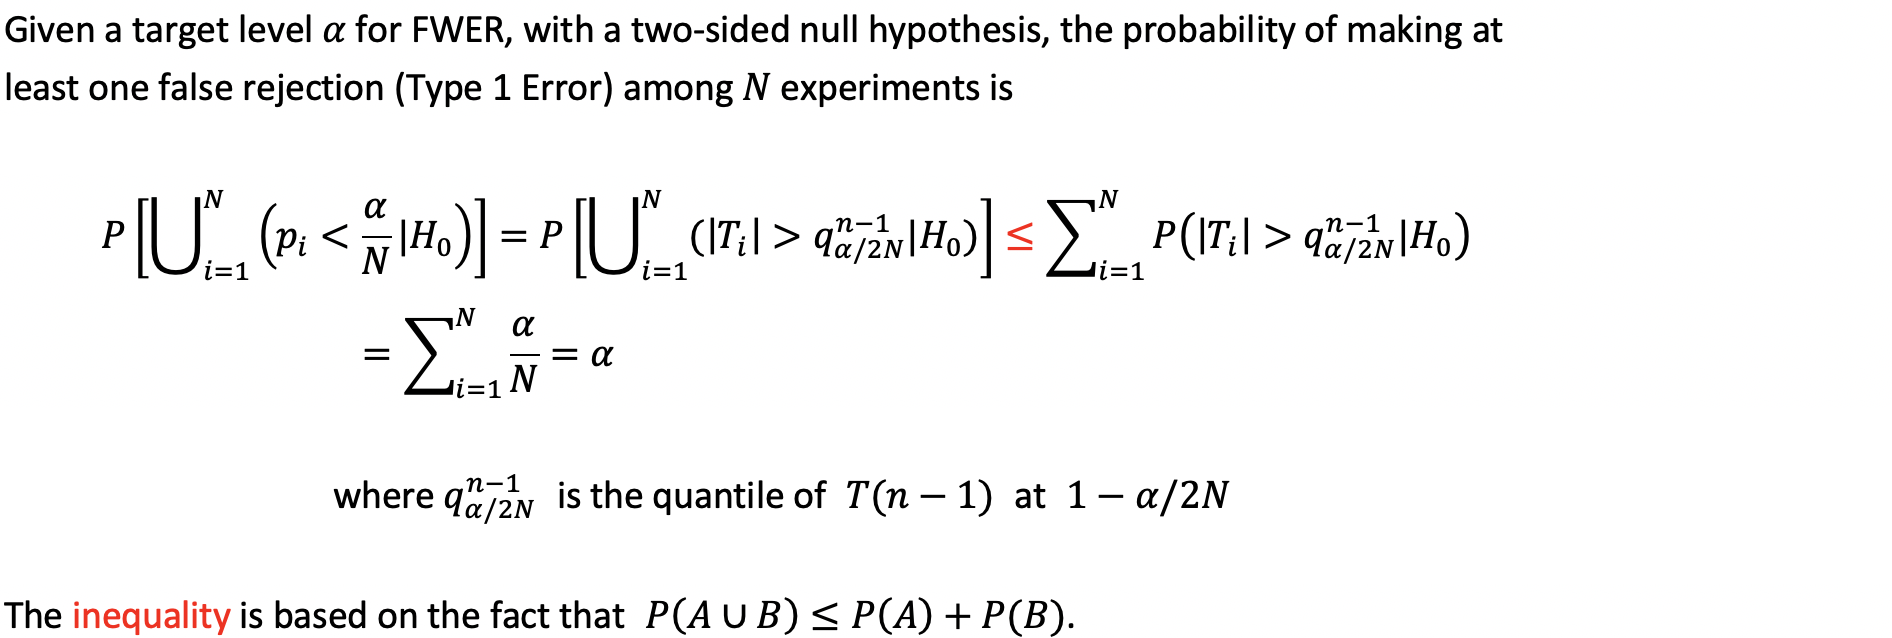

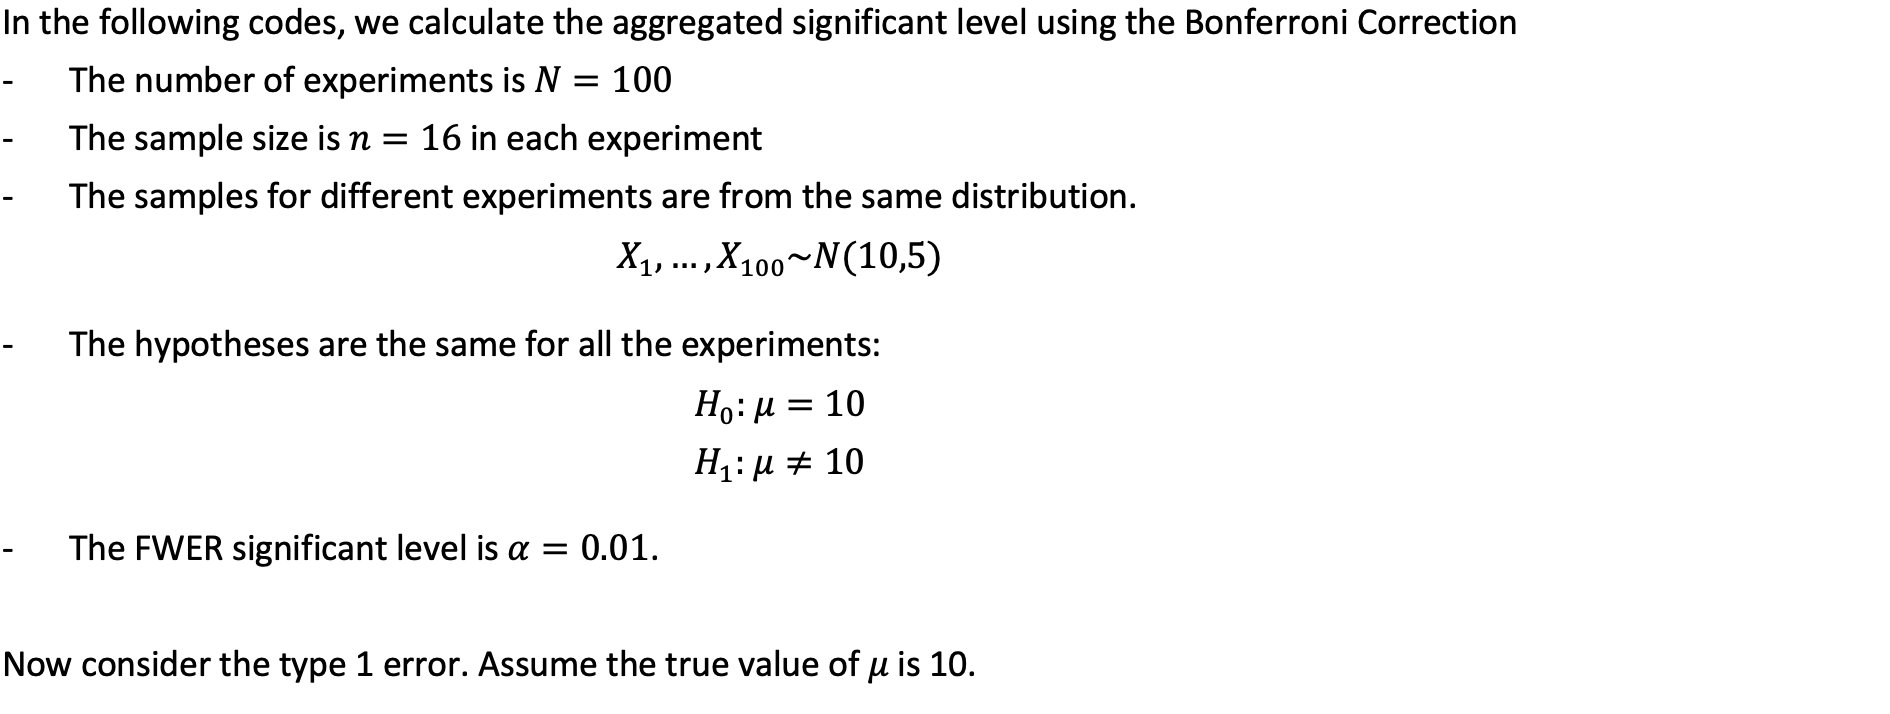

In [11]:
n_experiment = 100
alpha        = 0.05
n_test       = 100
sample_size  = 16
alpha_N = [np.nan]*n_experiment
for e in range(n_experiment):
    result = pd.DataFrame(columns=['T','c','p','reject'])
    for i in range(n_test):
        sample = np.random.normal(true_mu,np.sqrt(true_sigma2),sample_size)
        sample_mean = np.mean(sample)
        result.loc[i,'T'] = abs(np.sqrt(sample_size)*(sample_mean-true_mu)/np.sqrt(np.var(sample,ddof=1)))
        result.loc[i,'c'] = t.ppf(1-alpha/(2*n_test), df=sample_size-1)
        result.loc[i,'p'] = (1-t.cdf(result.loc[i,'T'], df=sample_size-1))*2
        result.loc[i,'reject'] = int(result.loc[i,'T']>result.loc[i,'c'])
    rejected = result[result['reject']==1].sort_values(by='p')
    alpha_N[e] = len(rejected)
len([i for i in alpha_N if i >0])/len(alpha_N)

0.04

- With the Bonferroni Correction, the aggregate level is controlled to be close to 5%. 
- The table below shows a few tests in in one experiment. When using Bonferroni Correction, the critical value (column c) is very conservative, leading to tiny rejection regions. 

In [12]:
result.head()

,T,c,p,reject
0,2.409769,4.416613,0.029261,0
1,0.543707,4.416613,0.594633,0
2,1.183635,4.416613,0.254977,0
3,2.260523,4.416613,0.039089,0
4,0.269791,4.416613,0.790998,0


## 2. False Discovery Rate (FDR)
- ### [FDR](https://en.wikipedia.org/wiki/False_discovery_rate) is the expected ratio of the number of false positive classifications (false discoveries) to the total number of positive classifications (rejections of the null).
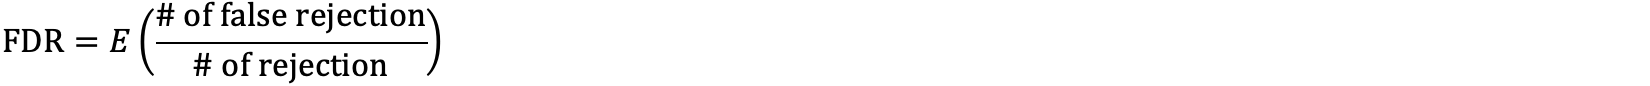
- ### [Benjamin–Hochberg Method](https://en.wikipedia.org/wiki/False_discovery_rate)
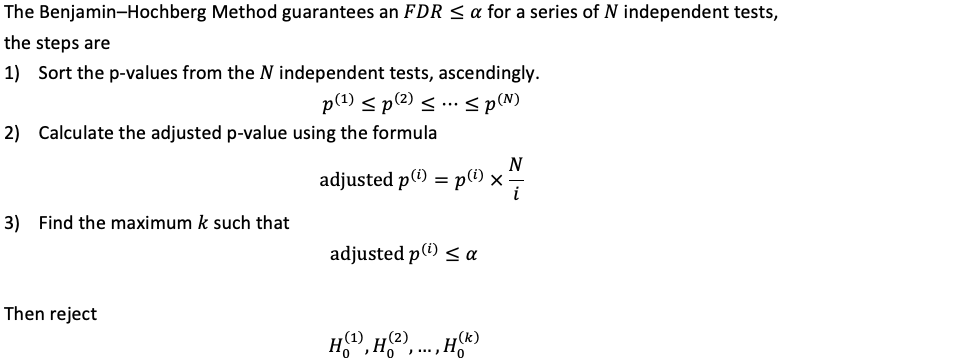

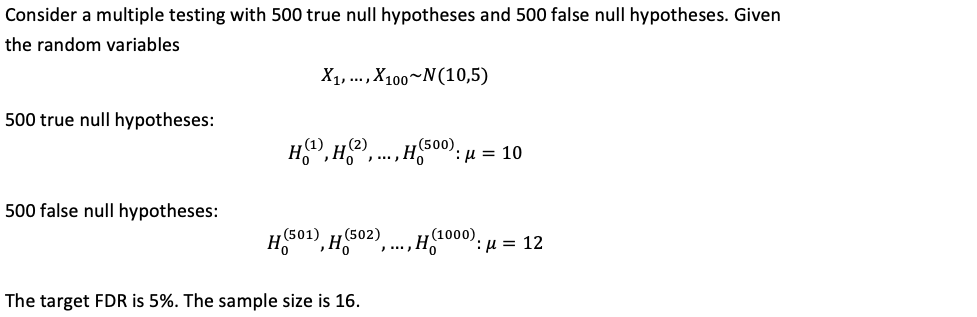

In [13]:
##### True parameters
true_mu     = 10
true_sigma2 = 5

##### true h0_1 and false h0_2
h0_1        = 12
h0_2        = 10

##### number of tests
n_test      = 1000

##### sample size
sample_size = 16

##### Target FDR
FDR_Target  = 0.05


result      = pd.DataFrame(columns=['T','p','h0'])
for i in range(n_test):
    sample = np.random.normal(true_mu,np.sqrt(true_sigma2),sample_size)
    sample_mean = np.mean(sample)
    
    if i<(n_test/2):
        result.loc[i,'h0'] = 'False'
        result.loc[i,'T']  = abs(np.sqrt(sample_size)*(sample_mean-h0_1)/np.sqrt(np.var(sample,ddof=1)))
    else:
        result.loc[i,'h0'] = 'True'
        result.loc[i,'T']  = abs(np.sqrt(sample_size)*(sample_mean-h0_2)/np.sqrt(np.var(sample,ddof=1)))
    
    result.loc[i,'p']  = (1-t.cdf(result.loc[i,'T'], df=sample_size-1))*2

result               = result.sort_values(by='p').reset_index()
result['rank']       = range(1,n_test+1)
result['adjusted_p'] = result['p']*n_test/result['rank']
result['reject_withoutBH'] = result['p'].apply(lambda x: 'reject' if x < FDR_Target else 'do not reject')
result['reject_BH']  = result['adjusted_p'].apply(lambda x: 'reject' if x < FDR_Target else 'do not reject')
result['change_int'] = ((result['p']<FDR_Target) & (result['adjusted_p']>FDR_Target)).astype(int)
result['change_str'] = result['change_int'].apply(lambda x: 'yes' if x==1 else 'no')
result

,index,T,p,h0,rank,adjusted_p,reject_withoutBH,reject_BH,change_int,change_str
0,283,11.41657,0.0,False,1,0.000009,reject,reject,0,no
1,290,8.698179,0.0,False,2,0.000151,reject,reject,0,no
2,362,7.972843,0.000001,False,3,0.000299,reject,reject,0,no
3,427,7.615275,0.000002,False,4,0.000393,reject,reject,0,no
4,125,7.531573,0.000002,False,5,0.000359,reject,reject,0,no
...,...,...,...,...,...,...,...,...,...,...
995,987,0.01583,0.987579,True,996,0.991545,do not reject,do not reject,0,no
996,725,0.01379,0.989179,True,997,0.992155,do not reject,do not reject,0,no
997,989,0.004789,0.996242,True,998,0.998239,do not reject,do not reject,0,no
998,761,0.003161,0.997519,True,999,0.998518,do not reject,do not reject,0,no


**The figure below plots the p-values and the adjusted p-values for the 1000 tests.**

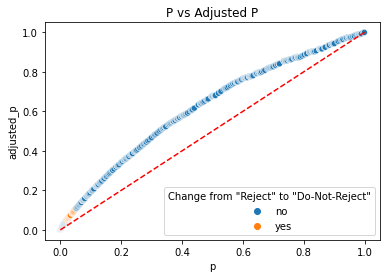

In [14]:
sns.scatterplot(data=result,x='p',y='adjusted_p',hue='change_str').set(title='P vs Adjusted P')
plt.plot([0,1], [0,1], linestyle='--', color='red')
plt.legend(title='Change from "Reject" to "Do-Not-Reject"', loc='lower right')
plt.show()

**Same numbers but only showing the range of low values.**
- These orange dots represent tests where decisions change. 
- If conventional p-values are used, H0 would be rejected, but when adjusted p-values are used, these decisions in these tests become 'fail to reject'.

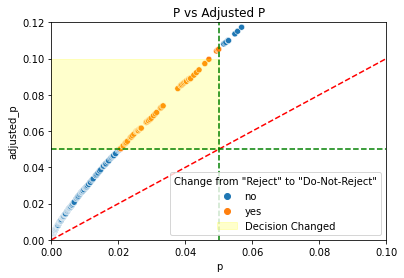

In [15]:
sns.scatterplot(data=result,x='p',y='adjusted_p',hue='change_str').set(title='P vs Adjusted P')
plt.plot([0,1], [0,1], linestyle='--', color='red')
plt.axhline(y=0.05, color='green', linestyle='--')
plt.axvline(x=0.05, color='green', linestyle='--')
plt.xlim(0,0.1)
plt.ylim(0,0.12)
x=np.array([0,0.05])
y1=np.array([0.05,0.05])
y2=np.array([0.1,0.1])       
plt.fill_between(x, y1, y2, color='yellow', alpha=0.2, label='Decision Changed')
plt.legend(title='Change from "Reject" to "Do-Not-Reject"', loc='lower right')
plt.show()

**The codes below compare the test results with and without the Benjamin–Hochberg Method**
- As expected, the Benjamin–Hochberg Method guaranteed a FDR < pre-specified value(0.05). 
- The cost is that the Benjamin–Hochberg Method increased the Type 2 Error rate. 

In [16]:
BH_effect = pd.DataFrame(columns=['BH','N_Reject','N_do_not_Reject'])
BH_effect.loc[0,'BH']              = 'without_BH'
BH_effect.loc[0,'N_Reject']        = len(result[result['reject_withoutBH']=='reject'])
BH_effect.loc[0,'N_do_not_Reject'] = len(result[result['reject_withoutBH']=='do not reject'])
BH_effect.loc[0,'False_Positive']  = len(result[(result['h0']=='True') \
                                                & (result['reject_withoutBH']=='reject')])
BH_effect.loc[0,'False_Negative']  = len(result[(result['h0']=='False') \
                                                & (result['reject_withoutBH']=='do not reject')])
BH_effect.loc[1,'BH']              = 'with_BH'
BH_effect.loc[1,'N_Reject']        = len(result[result['reject_BH']=='reject'])
BH_effect.loc[1,'N_do_not_Reject'] = len(result[result['reject_BH']=='do not reject'])
BH_effect.loc[1,'False_Positive']  = len(result[(result['h0']=='True') & (result['reject_BH']=='reject')])
BH_effect.loc[1,'False_Negative']  = len(result[(result['h0']=='False') & (result['reject_BH']=='do not reject')])

BH_effect['Type 1 Error Rate']     = BH_effect['False_Positive']/500
BH_effect['Type 2 Error Rate']     = BH_effect['False_Negative']/500
BH_effect['False Discovery Rate']  = BH_effect['False_Positive']/BH_effect['N_Reject']

BH_effect

,BH,N_Reject,N_do_not_Reject,False_Positive,False_Negative,Type 1 Error Rate,Type 2 Error Rate,False Discovery Rate
0,without_BH,475,525,23.0,48.0,0.046,0.096,0.048421
1,with_BH,409,591,11.0,102.0,0.022,0.204,0.026895
